In [31]:
## Import dependencies
import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import matplotlib
import time

In [32]:
iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278


In [ ]:
## Computing feature importances of different feature types

importances_spectral = []
importances_statistical = []
importances_temporal = []
importances_all = []
importances_afs = []

start_time = time.time()
for i in tqdm(range(len(stations))):
    X = np.loadtxt("spectrum_features_1minute/Z_1_25/"+stations[i]+".txt")
    y = np.loadtxt("spectrum_features_1minute/Z_1_25/"+stations[i]+"_labels.txt")
    X = StandardScaler().fit_transform(X)
    X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.20, random_state = 101)
    forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_Train, y_Train)
    importances_afs.append(forest.feature_importances_)
    
    
    ## statistical importances
    X1 = np.loadtxt("tsfel_features/statistical/"+stations[i]+".txt")
    y = np.loadtxt("tsfel_features/statistical/"+stations[i]+"_labels.txt")
    X = StandardScaler().fit_transform(X)
    X_Train, X_Test, y_Train, y_Test = train_test_split(X1, y, test_size = 0.20, random_state = 101)
    forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_Train, y_Train)
    importances_statistical.append(forest.feature_importances_)
        
    ## temporal importances
    X2 = np.loadtxt("tsfel_features/temporal/"+stations[i]+".txt")
    y = np.loadtxt("tsfel_features/temporal/"+stations[i]+"_labels.txt")
    X = StandardScaler().fit_transform(X)
    X_Train, X_Test, y_Train, y_Test = train_test_split(X2, y, test_size = 0.20, random_state = 101)
    forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_Train, y_Train)
    importances_temporal.append(forest.feature_importances_)
    
    ## spectral importances
    X3 = np.loadtxt("tsfel_features/spectral/"+stations[i]+".txt")
    y = np.loadtxt("tsfel_features/spectral/"+stations[i]+"_labels.txt")
    X = StandardScaler().fit_transform(X)
    X_Train, X_Test, y_Train, y_Test = train_test_split(X3, y, test_size = 0.20, random_state = 101)
    forest = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_Train, y_Train)
    importances_spectral.append(forest.feature_importances_)
    
    ## all importances
    X = np.hstack([X1,X2,X3])
    y = np.loadtxt("tsfel_features/spectral/"+stations[i]+"_labels.txt")
    X = StandardScaler().fit_transform(X)
    X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.20, random_state = 101)
    forest = RandomForestClassifier(random_state=0, n_estimators=50).fit(X_Train, y_Train)
    importances_all.append(forest.feature_importances_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

 67%|██████▋   | 10/15 [02:57<01:41, 20.32s/it]

In [4]:
## defining the order of stations according to the number of available waveforms
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)

In [5]:
## Normalizing the feature importances at individual stations to allow comparisons across stations.
importances_norm = []

for i in range(len(importances_afs)):
    importances_norm.append(importances_afs[i]/np.max(importances_afs[i]))
    
freq = np.fft.fftfreq(n=1500, d=0.02)

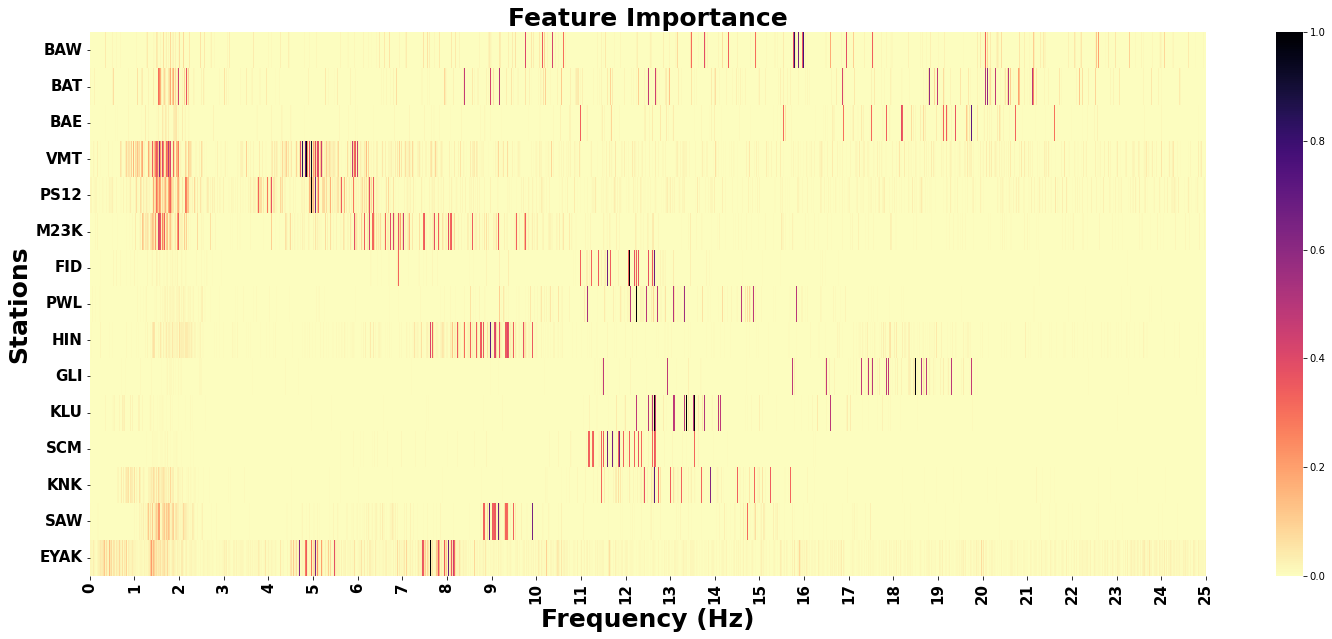

In [6]:
## Plotting the afs feature importances. 
plt.rcParams['axes.linewidth'] = 2
feature_importance = pd.DataFrame(np.array(importances_norm)[:,0:1500][order], columns=freq[0:1500])
plt.figure(figsize=[25,10])
ax = sns.heatmap(feature_importance, cmap="magma_r", linewidth=0.0005)
ax.set_xticks(np.linspace(0,1500,26))
ax.set_xticklabels([str(i) for i in range(26)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
ax.set_xlabel('Frequency (Hz)', fontsize=25, fontweight='bold')
ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Feature Importance', fontsize=25, fontweight='bold')

#plt.savefig('Manuscript_Figures/Feature_importance_Comparison.eps')

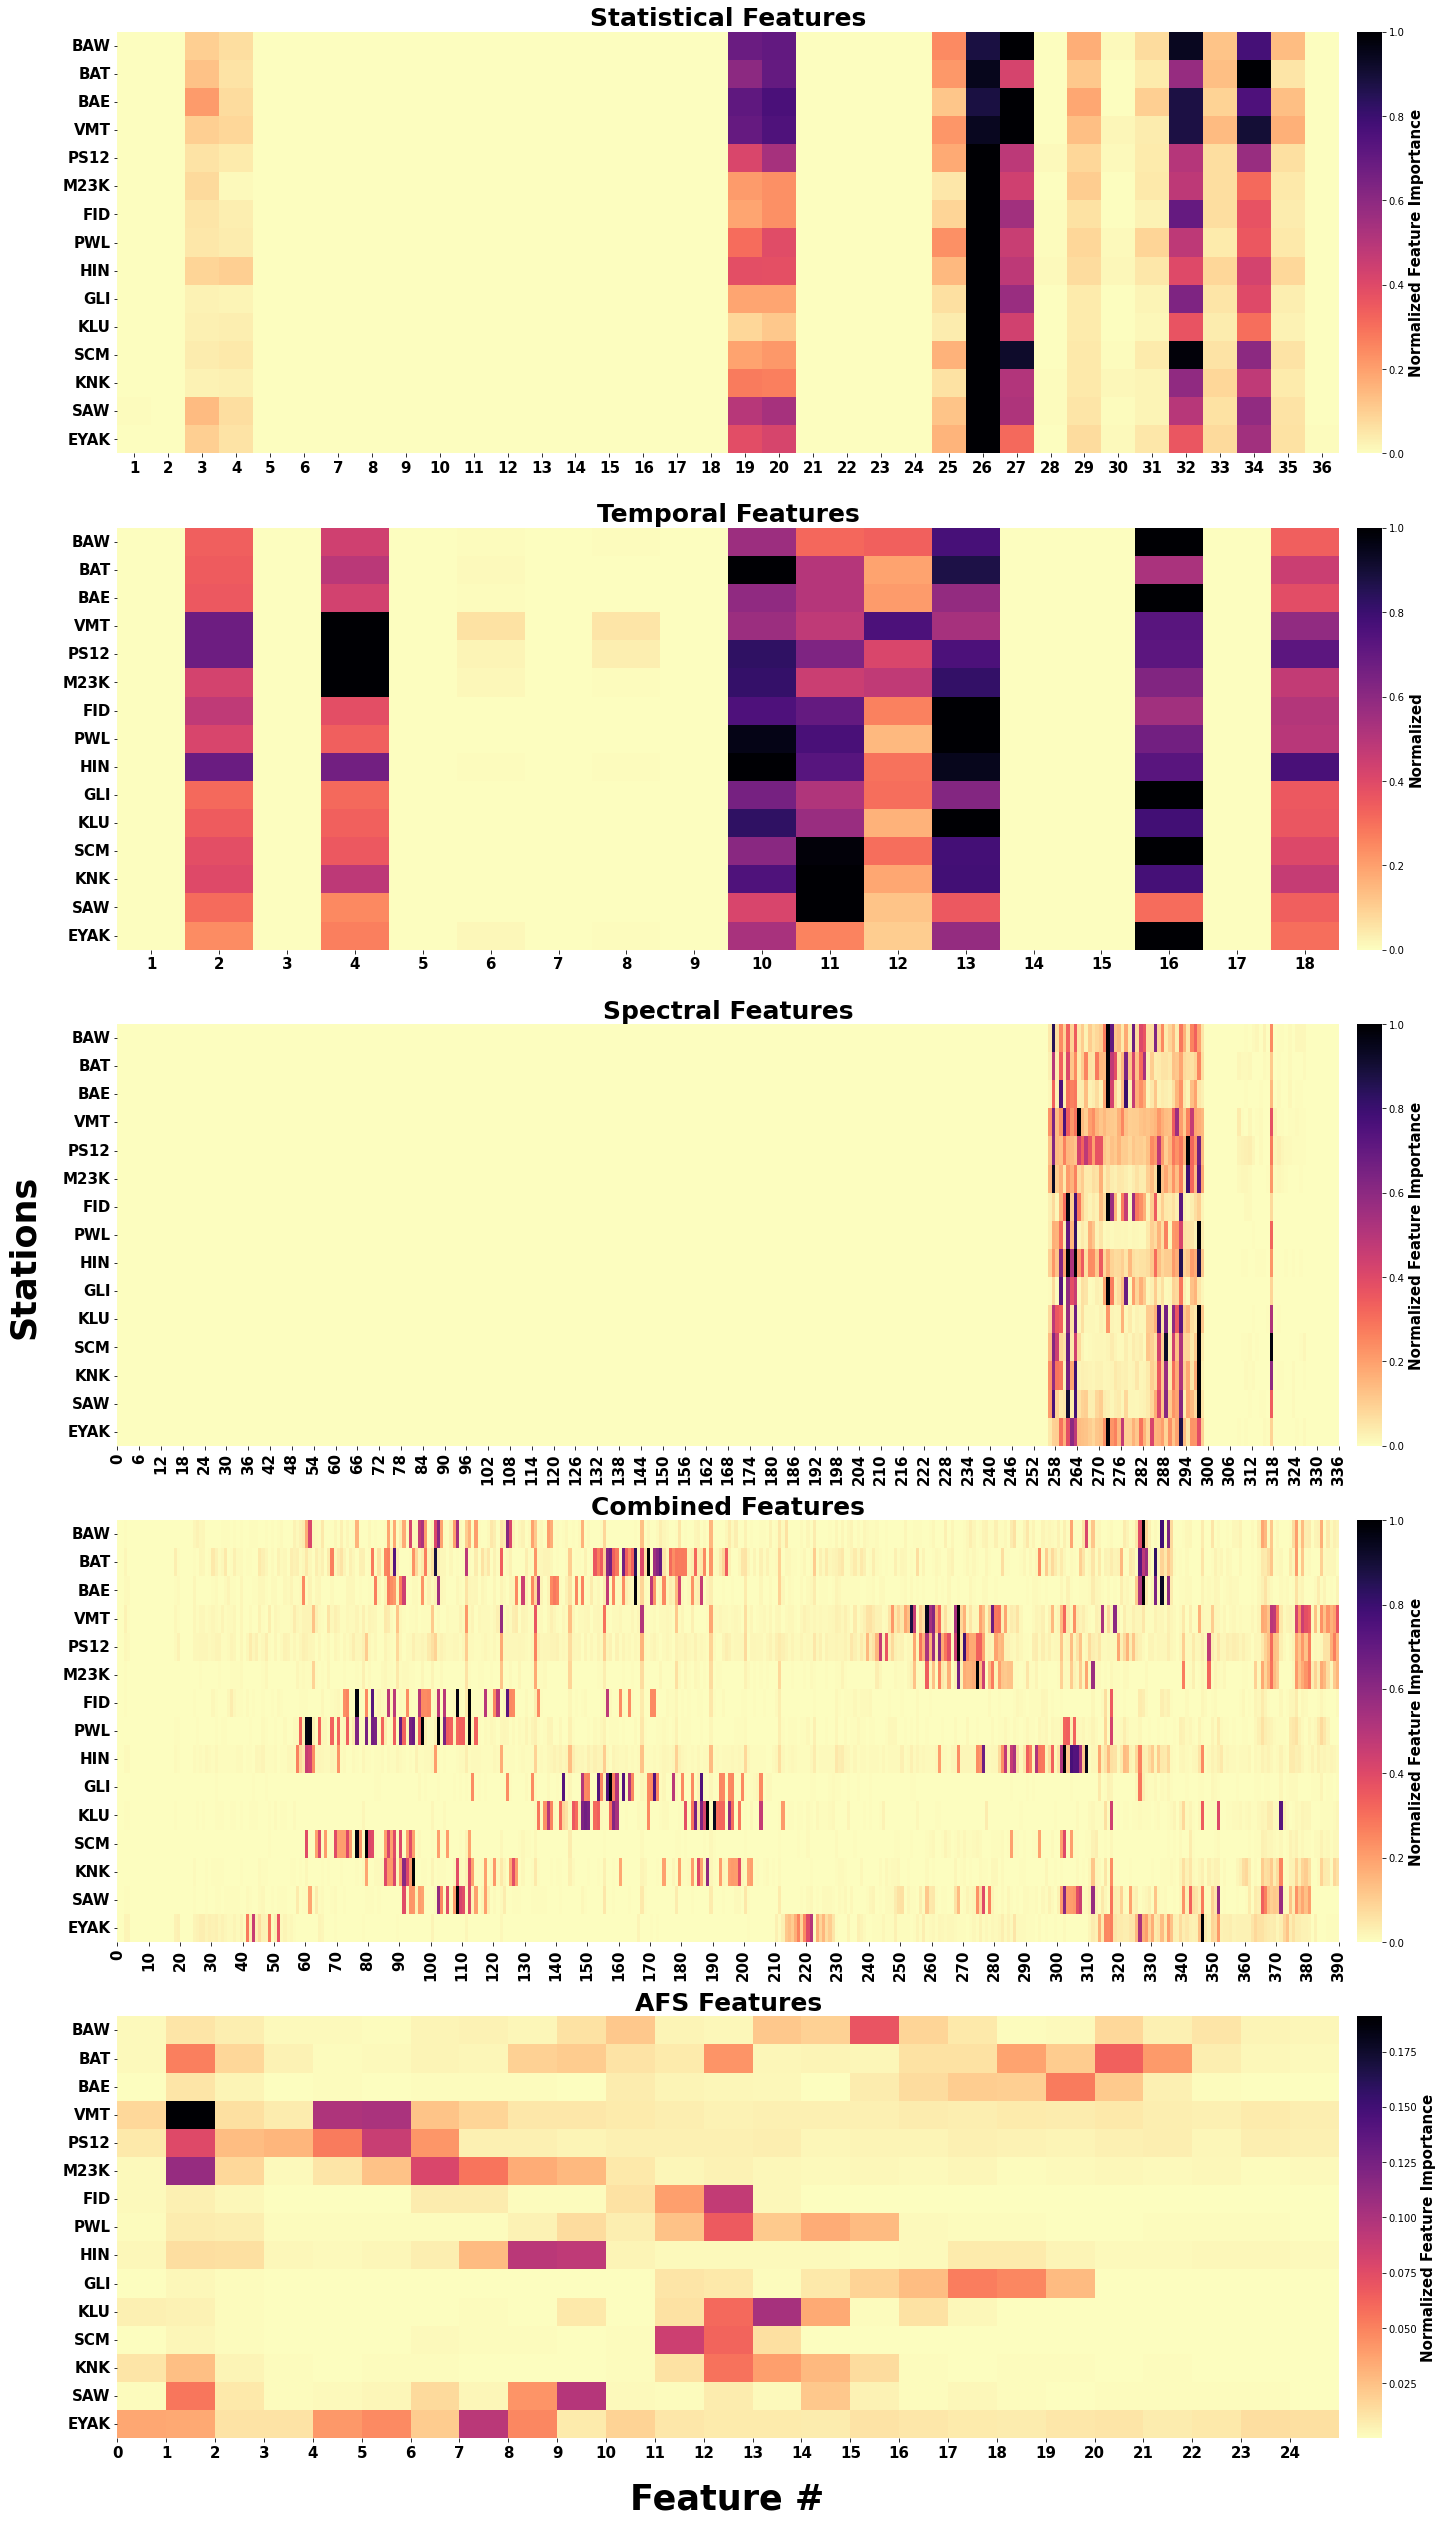

In [10]:
## Plotting feature importances of all feature types and across all stations. 


## getting the order of the stations according to number of available waveforms. 
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)


## Normalizing importances of temporal features. 
importances_norm_temp = []

for i in range(len(importances_temporal)):
    importances_norm_temp.append(importances_temporal[i]/np.max(importances_temporal[i]))
    
plt.rcParams['axes.linewidth'] = 2
grid_spec = {"width_ratios": (25, 0.5)}

fig, ax1 = plt.subplots(5,2, gridspec_kw=grid_spec, figsize=[20,35])
ax = sns.heatmap(np.array(importances_norm_temp)[order],cbar_ax=ax1[1][1], ax=ax1[1][0], cmap = 'magma_r')
ax.set_xticklabels([str(i) for i in range(1,len(importances_norm_temp[0])+1)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Temporal Features', fontsize=25, fontweight='bold')
ax1[1][1].set_ylabel('Normalized', fontsize=15, fontweight='bold')


importances_norm_stat = []

for i in range(len(importances_statistical)):
    importances_norm_stat.append(importances_statistical[i]/np.max(importances_statistical[i]))
    
ax = sns.heatmap(np.array(importances_norm_stat)[order],cbar_ax=ax1[0][1], ax=ax1[0][0], cmap = 'magma_r')
ax.set_xticklabels([str(i) for i in range(1,len(importances_norm_stat[0])+1)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Statistical Features', fontsize=25, fontweight='bold')
ax1[0][1].set_ylabel('Normalized Feature Importance', fontsize=15, fontweight='bold')


importances_norm_spec = []

for i in range(len(importances_spectral)):
    importances_norm_spec.append(importances_spectral[i]/np.max(importances_spectral[i]))
    

ax = sns.heatmap(np.array(importances_norm_spec)[order],cbar_ax=ax1[2][1], ax=ax1[2][0], cmap = 'magma_r')
ax.set_xticks(np.linspace(0,336,57))
ax.set_xticklabels([str(i) for i in range(0,337,6)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Spectral Features', fontsize=25, fontweight='bold')
ax1[2][1].set_ylabel('Normalized Feature Importance', fontsize=15, fontweight='bold')



importances_norm_all = []

for i in range(len(importances_all)):
    importances_norm_all.append(importances_all[i]/np.max(importances_all[i]))
    
ax = sns.heatmap(np.array(importances_norm_all)[order],cbar_ax= ax1[3][1], ax=ax1[3][0], cmap = 'magma_r')
ax.set_xticks(np.linspace(0,390,40))
ax.set_xticklabels([str(i) for i in range(0,400,10)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Combined Features', fontsize=25, fontweight='bold')
ax1[3][1].set_ylabel('Normalized Feature Importance', fontsize=15, fontweight='bold')


importances_norm_afs = []

for i in range(len(importances_afs)):
    importances_norm_afs.append(importances_afs[i]/np.max(importances_afs[i]))

feature_importance = pd.DataFrame(np.array(importances_norm_afs)[:,0:1500][order], columns=freq[0:1500])
feature_i = feature_importance.values
smoothed_fi = []

for i in range(len(feature_importance)):
    win_sum = []
    for j in range(0,len(feature_i[i]), 60):
            win_sum.append(np.sum(feature_i[i,j:j+60])/60)
    smoothed_fi.append(win_sum)
    
ax = sns.heatmap(smoothed_fi,cbar_ax= ax1[4][1], ax=ax1[4][0], cmap = 'magma_r')
ax.set_xticks(np.linspace(0,24,25))
ax.set_xticklabels([str(i) for i in range(25)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('AFS Features', fontsize=25, fontweight='bold')
ax1[4][1].set_ylabel('Normalized Feature Importance', fontsize=15, fontweight='bold')


fig.supxlabel('Feature #', y = 0.0, fontsize = 35, fontweight = 'bold')
fig.supylabel('Stations', x = 0.0, fontsize = 35, fontweight = 'bold')

plt.tight_layout()

In [19]:
def top5_features(type = "spectral"):
    
    
    if type == "spectral":
        f = open("tsfel_features/spectral/feature_labels.txt",'r')
        mean_imp = np.mean(importances_norm_spec, axis = 0)
        
        
    elif type == "statistical":
        f = open("tsfel_features/statistical/feature_labels.txt",'r')
        mean_imp = np.mean(importances_norm_stat, axis = 0)
        
    elif type == "temporal":
        f = open("tsfel_features/temporal/feature_labels.txt",'r')
        mean_imp = np.mean(importances_norm_temp, axis = 0)




    fl = []
    for row in f:
        fl.append(row)

    labels = [fl[i].split('\n')[0] for i in range(len(fl))]
    top5 = np.array(labels)[np.argsort(mean_imp)[::-1][0:5]]
    top5_index = np.argsort(mean_imp)[::-1][0:5]
    
    return top5, top5_index, labels


_,_, labels_spec = top5_features(type = "spectral")
_,_, labels_stat = top5_features(type = "statistical")
_,_, labels_temp = top5_features(type = "temporal")

labels_all = labels_stat+labels_temp+labels_spec
mean_imp = np.mean(importances_norm_all, axis = 0)
top5_all = np.array(labels_all)[np.argsort(mean_imp)[::-1][0:5]]
top5_index_all = np.argsort(mean_imp)[::-1][0:5]

In [25]:
def top_features(i):
    return np.argsort(mean_imp)[::-1][0:i]

SPEC = []
SENS = []
ACC = []
DUR = []

for i in range(len(stations)):
    station = stations[i]
    ## all importances
    X1 = np.loadtxt("tsfel_features/statistical/"+station+".txt")
    X2 = np.loadtxt("tsfel_features/temporal/"+station+".txt")
    X3 = np.loadtxt("tsfel_features/spectral/"+station+".txt")
    X = np.hstack([X1,X2,X3])
    y = np.loadtxt("tsfel_features/spectral/"+station+"_labels.txt")
    X = StandardScaler().fit_transform(X)

    spec = []
    sens = []
    acc = []
    dur = []



    for i in tqdm(range(1,np.shape(X)[1]+1)):
        X_new = X[:,top_features(i)]
        X_Train, X_Test, y_Train, y_Test = train_test_split(X_new, y, test_size = 0.20, random_state = 101)
        start = time.process_time()
        forest = RandomForestClassifier(random_state=0, n_estimators=50).fit(X_Train, y_Train)
        dur.append(time.process_time() - start)
        predictionforest = forest.predict(X_Test)
        #print(confusion_matrix(Y_Test,predictionforest))
        #print(classification_report(Y_Test,predictionforest))

        tn, fp, fn, tp = confusion_matrix(y_Test, predictionforest).ravel()
        spec.append(tn / (tn+fp))
        sens.append(tp / (tp+fn))
        acc.append(accuracy_score(y_Test, predictionforest))
        
    ACC.append(acc)
    SPEC.append(spec)
    SENS.append(sens)
    DUR.append(dur)

100%|██████████| 390/390 [01:55<00:00,  3.38it/s]


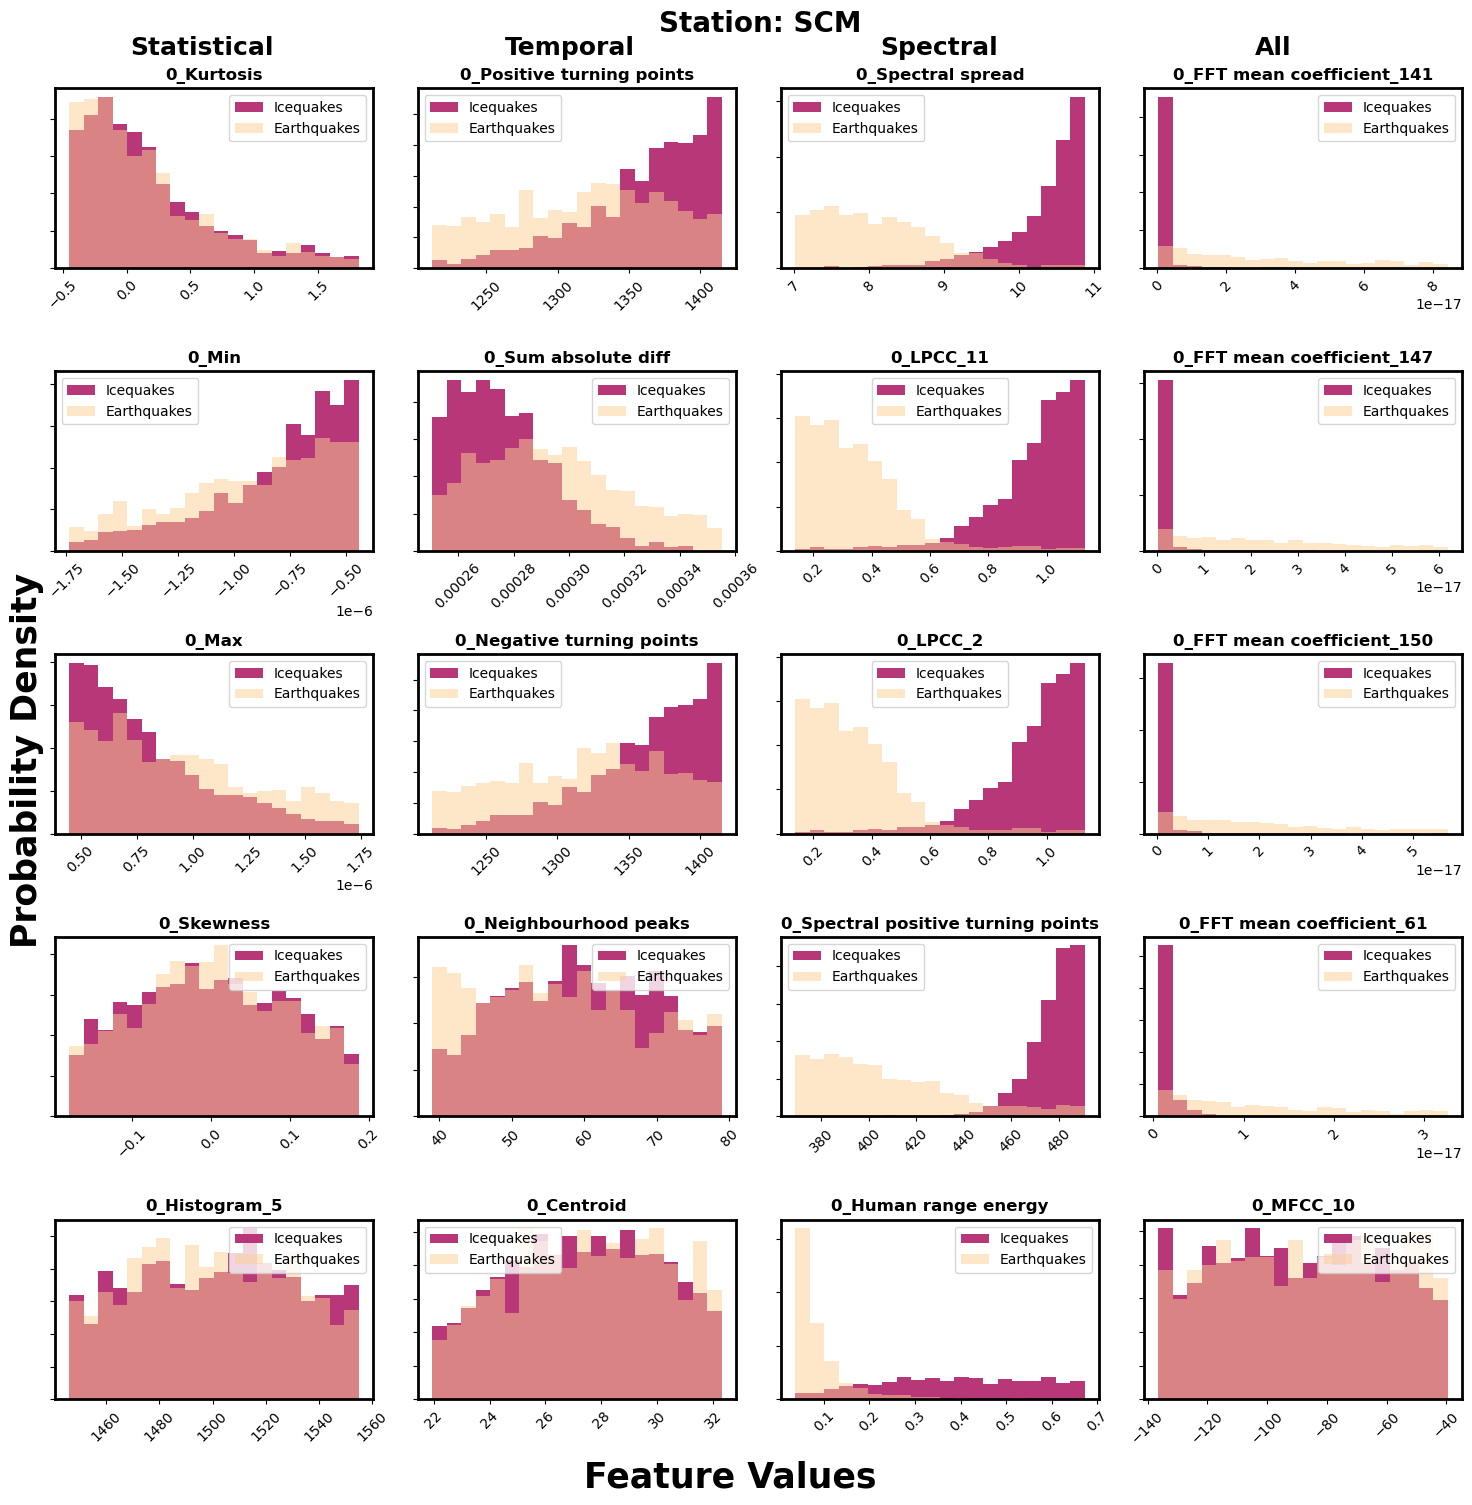

In [28]:
## extracting discrete colors from individual colormaps. 

cmap = matplotlib.cm.get_cmap('magma')

c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)


## defining a new figure
fig, ax = plt.subplots(nrows = 5, ncols = 4, figsize=[15,15], dpi = 100)


## setting up the station name


## Test for 4 kind of stations - (i) Few waveforms and low k - (BAW/BAE/BAT)
## (ii) slightly more number of waveforms but poor SNR - (PS12/VMT)
## (iii) decent number of waveforms and k - (FID, PWL, KLU, SCM, KNK)
## (iv) decent number of waveforms but poor SNR (HIN, EYAK, M23K)



station = "SCM"



# loading the features of specified type and specified station
f_type = "statistical"
X1 = np.loadtxt("tsfel_features/"+f_type+"/"+station+".txt")
y = np.loadtxt("tsfel_features/"+f_type+"/"+station+"_labels.txt") # loading the labels of each events

iq_idx = np.where(y == 1)[0] ## loading the index of icequakes
eq_idx = np.where(y == 0)[0] ## loading the index of earthquakes

top5, order, _= top5_features(type = f_type)
## top 5 refers to the labels of top 5 features. 
## order refers to the index of the top 5 features. 
## So we will go over icequakes and earthquakes and select most important features and plot them. 
p1 = 15 # percentile lower limit
p2 = 85 # percentile upper limit


for i in range(len(order)):
    ax[i][0].hist(X1[iq_idx][:,order[i]],bins = 20, 
                     range= (np.percentile(X1[:,order[i]],p1),np.percentile(X1[:,order[i]],p2)),
                    density=True, color = c3,label = "Icequakes")
    
    ## Depending on the outlier, how far they are from typical distribution, it may be hard to visualize the
    ## difference 
    
    
    
    ax[i][0].hist(X1[eq_idx][:,order[i]],bins = 20,
                     range= (np.percentile(X1[:,order[i]],p1),np.percentile(X1[:,order[i]],p2)),alpha=0.5,
                    density=True, color = c5, label = "Earthquakes")
    ax[i][0].set_yticklabels([])
    ax[i][0].set_title(top5[i], fontsize = 12, fontweight='bold')
    ax[i][0].legend()
    ax[i][0].tick_params(axis='x', labelrotation = 45)

    
    
    
    
    
    
f_type = "temporal"
X2= np.loadtxt("tsfel_features/"+f_type+"/"+station+".txt") # loading the features of specified type 
#and specified station
y = np.loadtxt("tsfel_features/"+f_type+"/"+station+"_labels.txt") # loading the labels of each events

iq_idx = np.where(y == 1)[0] ## loading the index of icequakes
eq_idx = np.where(y == 0)[0] ## loading the index of earthquakes

top5, order, _= top5_features(type = f_type)
p1 = 15 # percentile lower limit
p2 = 85 # percentile upper limit

for i in range(len(order)):
    ax[i][1].hist(X2[iq_idx][:,order[i]],bins = 20, color = c3,
                     range= (np.percentile(X2[:,order[i]],p1),np.percentile(X2[:,order[i]],p2)),
                    density=True, label = "Icequakes")
    
    ax[i][1].hist(X2[eq_idx][:,order[i]],bins = 20, color = c5,
                     range= (np.percentile(X2[:,order[i]],p1),np.percentile(X2[:,order[i]],p2)),alpha=0.5,
                    density=True, label = "Earthquakes")
    ax[i][1].set_yticklabels([])
    ax[i][1].set_title(top5[i], fontsize = 12, fontweight='bold')
    ax[i][1].legend()
    ax[i][1].tick_params(axis='x', labelrotation = 45)
    

    

    
    
f_type = "spectral"
X3 = np.loadtxt("tsfel_features/"+f_type+"/"+station+".txt") # loading the features of specified type 
#and specified station
y = np.loadtxt("tsfel_features/"+f_type+"/"+station+"_labels.txt") # loading the labels of each events

iq_idx = np.where(y == 1)[0] ## loading the index of icequakes
eq_idx = np.where(y == 0)[0] ## loading the index of earthquakes

top5, order, _= top5_features(type = f_type)
p1 = 15 # percentile lower limit
p2 = 85 # percentile upper limit


for i in range(len(order)):
    ax[i][2].hist(X3[iq_idx][:,order[i]],bins = 20, color = c3,
                     range= (np.percentile(X3[:,order[i]],p1),np.percentile(X3[:,order[i]],p2)),
                    density=True, label = "Icequakes")
    
    ax[i][2].hist(X3[eq_idx][:,order[i]],bins = 20, color = c5,
                     range= (np.percentile(X3[:,order[i]],p1),np.percentile(X3[:,order[i]],p2)),alpha=0.5,
                    density=True, label = "Earthquakes")
    ax[i][2].set_yticklabels([])
    ax[i][2].set_title(top5[i], fontsize = 12, fontweight='bold')
    ax[i][2].legend()
    ax[i][2].tick_params(axis='x', labelrotation = 45)

    
    
    
    
    
top5, order = top5_all, top5_index_all
X = np.hstack([X1,X2,X3])
p1 = 30 # percentile lower limit
p2 = 70 # percentile upper limit


for i in range(len(order)):
    ax[i][3].hist(X[iq_idx][:,order[i]],bins = 20, color = c3,
                     range= (np.percentile(X[:,order[i]],p1),np.percentile(X[:,order[i]],p2)),
                    density=True, label = "Icequakes")
    
    ax[i][3].hist(X[eq_idx][:,order[i]],bins = 20, color = c5,
                     range= (np.percentile(X[:,order[i]],p1),np.percentile(X[:,order[i]],p2)),alpha=0.5,
                    density=True, label = "Earthquakes")
    ax[i][3].set_yticklabels([])
    ax[i][3].set_title(top5[i], fontsize = 12, fontweight='bold')
    ax[i][3].legend()
    ax[i][3].tick_params(axis='x', labelrotation = 45)
fig.supylabel('Probability Density', fontsize = 25, fontweight = 'bold')
fig.supxlabel('Feature Values', fontsize = 25, fontweight = 'bold')
fig.text(0.1, 0.97, 'Statistical', fontsize = 18, fontweight = 'bold')
fig.text(0.35, 0.97, 'Temporal', fontsize = 18, fontweight = 'bold')
fig.text(0.60, 0.97, 'Spectral', fontsize = 18, fontweight = 'bold')
fig.text(0.85, 0.97, 'All', fontsize = 18, fontweight = 'bold')
fig.suptitle("Station: "+station,x =0.52, y = 1, fontsize = 20, fontweight = 'bold')
plt.tight_layout()



In [27]:
## Create the heatmap for the above values

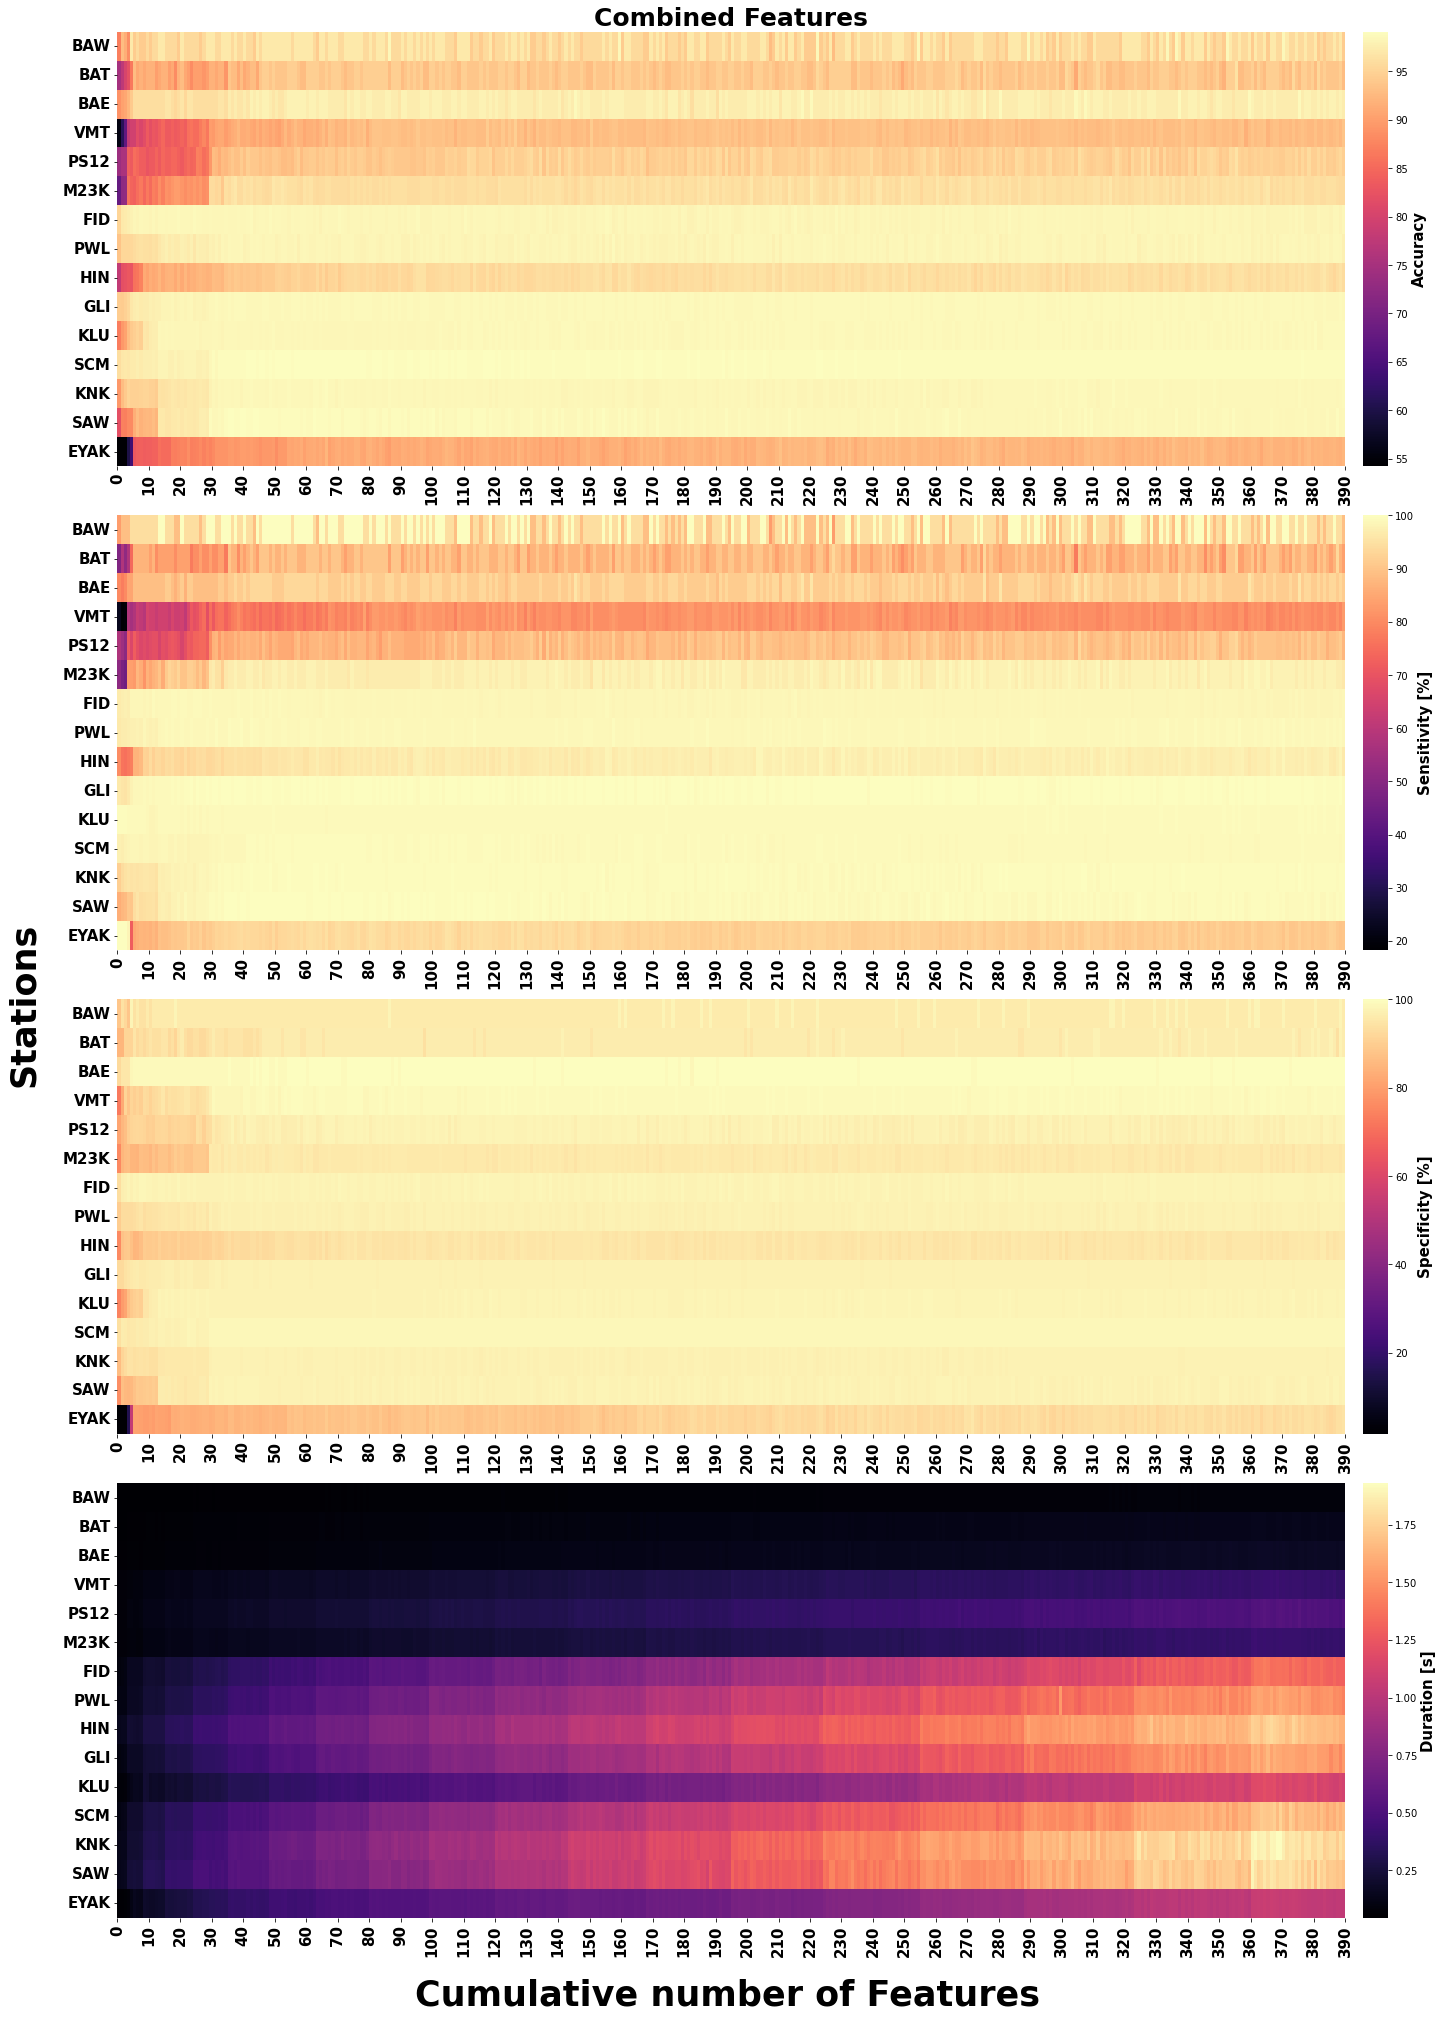

In [26]:
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)

    
plt.rcParams['axes.linewidth'] = 2
grid_spec = {"width_ratios": (25, 0.5)}

fig, ax1 = plt.subplots(4,2, gridspec_kw=grid_spec, figsize=[20,28])

ax = sns.heatmap(np.array(ACC)[order]*100,cbar_ax= ax1[0][1], ax=ax1[0][0], cmap = 'magma')
ax.set_xticks(np.linspace(0,390,40))
ax.set_xticklabels([str(i) for i in range(0,400,10)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
ax.set_title('Combined Features', fontsize=25, fontweight='bold')
ax1[0][1].set_ylabel('Accuracy', fontsize=15, fontweight='bold')

ax = sns.heatmap(np.array(SENS)[order]*100,cbar_ax= ax1[1][1], ax=ax1[1][0], cmap = 'magma')
ax.set_xticks(np.linspace(0,390,40))
ax.set_xticklabels([str(i) for i in range(0,400,10)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
#ax.set_title('Combined Features', fontsize=25, fontweight='bold')
ax1[1][1].set_ylabel('Sensitivity [%]', fontsize=15, fontweight='bold')


ax = sns.heatmap(np.array(SPEC)[order]*100,cbar_ax= ax1[2][1], ax=ax1[2][0], cmap = 'magma')
ax.set_xticks(np.linspace(0,390,40))
ax.set_xticklabels([str(i) for i in range(0,400,10)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
#ax.set_title('Combined Features', fontsize=25, fontweight='bold')
ax1[2][1].set_ylabel('Specificity [%]', fontsize=15, fontweight='bold')

    
ax = sns.heatmap(np.array(DUR)[order],cbar_ax= ax1[3][1], ax=ax1[3][0], cmap = 'magma')
ax.set_xticks(np.linspace(0,390,40))
ax.set_xticklabels([str(i) for i in range(0,400,10)], fontsize=15, fontweight='bold')
ax.set_yticklabels(stations[order], fontsize=15, fontweight='bold', rotation=0)
#ax.set_xlabel('Feature #', fontsize=25, fontweight='bold')
#ax.set_ylabel('Stations', fontsize=25, fontweight='bold')
#ax.set_title('Combined Features', fontsize=25, fontweight='bold')
ax1[3][1].set_ylabel('Duration [s]', fontsize=15, fontweight='bold')




fig.supxlabel('Cumulative number of Features', y = 0.0, fontsize = 35, fontweight = 'bold')
fig.supylabel('Stations', x = 0.0, fontsize = 35, fontweight = 'bold')

plt.tight_layout()